In [2]:
!pip install catboost seaborn scikit-learn

  Using cached catboost-1.1.1-cp37-none-manylinux1_x86_64.whl (76.6 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached plotly-5.11.0-py2.py3-none-any.whl (15.3 MB)
  Using cached tenacity-8.1.0-py3-none-any.whl (23 kB)


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as rmse
from catboost.utils import eval_metric

from scipy import stats
from scipy.stats import norm, skew #for some statistics
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import CatBoostEncoder
import numpy as np


pd.set_option('display.max_columns', None)

In [102]:
# st_code_snd - id станции отправления;
# st_code_rsv - id станции назначения;
# date_depart_year – год отправления;
# date_depart_month – месяц отправления;
# date_depart_week – неделя отправления;
# date_depart_day – день отправления;
# date_depart_hour – час отправления;
# fr_id - id груза;
# route_type - тип отправки;
# is_load – признак гружёности (1 - гружёный, 0 - порожний);
# rod – род подвижного состава;
# common_ch - id обобщённой характеристики вагона;
# vidsobst - вид собственности;
# distance - расстояние рейса;
# snd_org_id - id грузоотправителя;
# rsv_org_id – id грузополучателя;
# snd_roadid - id дороги отправления;
# rsv_roadid – id дороги назначения;
# snd_dp_id – id региона отправления;
# rsv_dp_id – id региона назначения;
# y – таргет (время в пути в часах).
# check nan
# drop where fr_id is nan and route_type is nan

df_train = pd.read_parquet(r"df_train.parquet")
df_train.head(10)

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y
0,wagonwagonwagontutu:)wagon,wagondigitalnewyearrailway:)happy,2021,11,45,12,14,3399.0,4.0,1,2,11.0,102.0,930.0,1098,5476,13,13,78,75,185.200000
1,railwaypgkhappyrailway:)railway,digitalhappynewyeardigital:)wagon,2021,4,15,17,16,2261.0,3.0,0,8,9.0,111.0,16.0,2974,6682,21,21,111,111,0.250000
2,railwaytutupgkpgk:)digital,pgkdigitalrailway:):)happy,2021,5,17,2,7,1089.0,3.0,1,8,9.0,111.0,879.0,2082,10729,9,9,67,23,109.133333
3,tuturailwaydigital2022:)digital,newyearnewyear20222022:)2022,2020,11,47,17,11,2261.0,4.0,0,8,975.0,103.0,8569.0,2974,10571,28,28,115,112,214.093056
4,railwaytutupgkpgk:)digital,pgkhappyrailwayhack:)railway,2020,12,52,25,5,1666.0,4.0,1,8,9.0,101.0,656.0,2082,9225,9,9,67,16,104.100000
5,hacknewyearrailway:)pgk,hackwagonhappy:)newyear,2021,5,21,28,11,2261.0,1.0,0,8,9.0,102.0,1021.0,6276,1316,23,23,10,67,49.150000
6,happynewyearpgk:)railway,hackwagon:):)tutu,2022,1,2,14,11,2261.0,1.0,0,8,12.0,111.0,4480.0,2974,2324,6,6,59,111,129.400000
7,tutuwagon2022hack:)pgk,newyearwagondigitalnewyear:)tutu,2021,11,44,5,22,2261.0,1.0,0,8,9.0,102.0,209.0,2974,1319,9,9,67,67,13.766667
8,railwaytutupgkhappy:)newyear,digitalhappynewyeardigital:)wagon,2020,5,20,13,0,2261.0,4.0,0,2,11.0,101.0,1680.0,2974,2142,27,27,126,125,118.233333
9,newyearrailwaypgknewyear:)hack,2022wagondigital:)digital,2020,10,43,19,11,714.0,3.0,1,8,975.0,103.0,3832.0,2942,14325,21,21,121,1,212.666667


In [39]:
df_train.describe()

,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y
count,4.219370e+06,4.219370e+06,4.219370e+06,4.219370e+06,4.219370e+06,4.218993e+06,4.215940e+06,4.219370e+06,4.219370e+06,4.115528e+06,4.115453e+06,4.180599e+06,4.219370e+06,4.219370e+06,4.219370e+06,4.219370e+06,4.219370e+06,4.219370e+06,4.219370e+06
mean,2.020898e+03,6.324458e+00,2.584229e+01,1.573212e+01,1.120691e+01,1.251422e+04,3.197628e+00,3.261248e-01,7.092808e+00,1.482579e+02,1.055863e+02,1.435254e+03,3.571899e+03,5.083052e+03,1.768395e+01,1.768395e+01,6.655668e+01,7.064748e+01,1.062546e+02
std,6.624948e-01,3.447391e+00,1.515971e+01,8.769932e+00,6.908402e+00,3.038947e+04,9.494948e-01,4.687936e-01,2.471687e+00,3.365967e+02,2.237800e+01,1.814291e+03,2.754049e+03,4.213619e+03,1.087458e+01,1.087458e+01,4.200729e+01,4.143892e+01,1.260761e+02
min,2.019000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.010000e+02,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.020000e+03,3.000000e+00,1.300000e+01,8.000000e+00,5.000000e+00,1.666000e+03,3.000000e+00,0.000000e+00,8.000000e+00,9.000000e+00,1.020000e+02,2.480000e+02,2.974000e+03,1.494000e+03,9.000000e+00,9.000000e+00,2.900000e+01,2.900000e+01,2.485611e+01
50%,2.021000e+03,6.000000e+00,2.500000e+01,1.600000e+01,1.200000e+01,2.261000e+03,3.000000e+00,0.000000e+00,8.000000e+00,9.000000e+00,1.020000e+02,7.400000e+02,2.974000e+03,2.974000e+03,1.800000e+01,1.800000e+01,6.700000e+01,6.700000e+01,7.598333e+01
75%,2.021000e+03,9.000000e+00,3.900000e+01,2.300000e+01,1.700000e+01,2.261000e+03,4.000000e+00,1.000000e+00,8.000000e+00,1.900000e+01,1.030000e+02,1.879000e+03,2.974000e+03,8.213000e+03,2.900000e+01,2.900000e+01,1.100000e+02,1.110000e+02,1.493167e+02
max,2.022000e+03,1.200000e+01,5.300000e+01,3.100000e+01,2.300000e+01,1.000990e+05,4.000000e+00,1.000000e+00,1.500000e+01,9.750000e+02,9.090000e+02,3.589600e+04,1.740100e+04,1.740100e+04,3.500000e+01,3.500000e+01,1.350000e+02,1.350000e+02,1.093677e+04


In [40]:
df_train.isna().sum()

st_code_snd               0
st_code_rsv               0
date_depart_year          0
date_depart_month         0
date_depart_week          0
date_depart_day           0
date_depart_hour          0
fr_id                   377
route_type             3430
is_load                   0
rod                       0
common_ch            103842
vidsobst             103917
distance              38771
snd_org_id                0
rsv_org_id                0
snd_roadid                0
rsv_roadid                0
snd_dp_id                 0
rsv_dp_id                 0
y                         0
dtype: int64

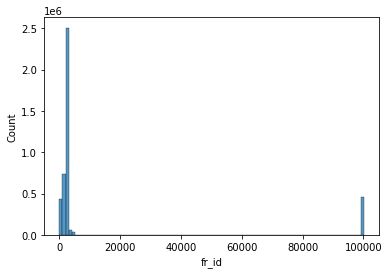

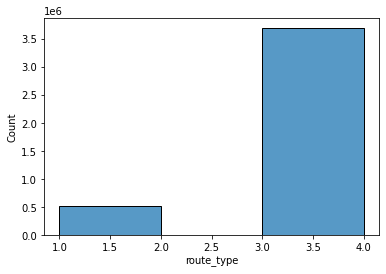

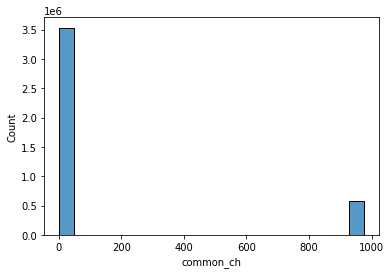

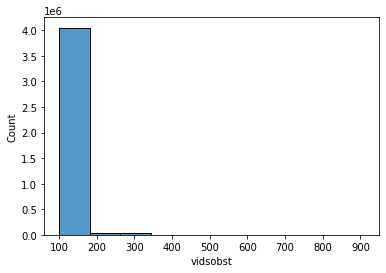

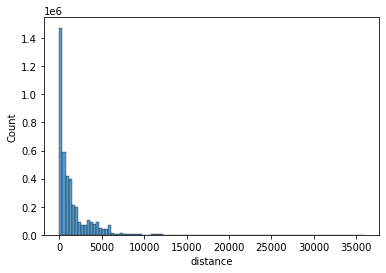

In [41]:
cols_with_na = df_train.columns[(df_train.isna().sum() > 0)]

for col in cols_with_na:
    sns.histplot(df_train, x=col, bins=min(100, df_train[col].nunique()))
    plt.show()

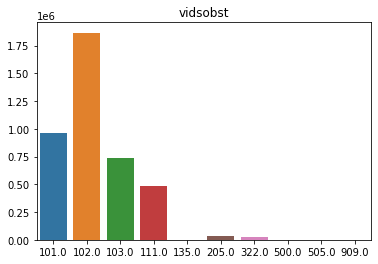

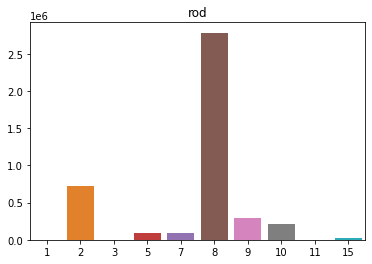

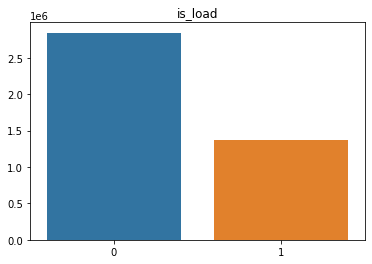

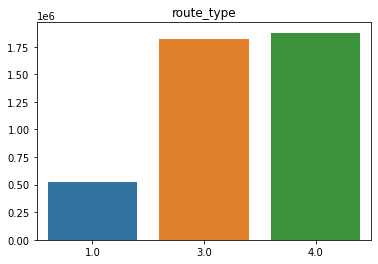

In [42]:
cat_cols = ['vidsobst', 'rod', 'is_load', 'route_type']
for col in cat_cols:
    tmp = df_train[col].value_counts()
    sns.barplot(x=tmp.index, y=tmp.values)
    plt.title(col)
    plt.show()

In [43]:
cat_cols.extend([col for col in df_train.columns if 'id' in col])
cat_cols += ['st_code_snd', 'st_code_rsv']
cat_cols = list(set(cat_cols))

In [157]:
cat_cols = ['st_code_snd', 'st_code_rsv']


def agg_df(df): 
    df_agg = df.groupby('st_code_snd').agg({
        "distance": [sum, np.mean, max, min, np.median, pd.Series.skew, pd.Series.kurtosis]
    })
 
    features_names = np.array([col + '_' + stat for col in ['snd_distance'] for stat in ['sum', 'mean', 'max', 'min', 'median', 'skew', 'kurtosis']]).flatten().tolist()   
    features_names = features_names
    res = pd.DataFrame(df_agg.values, columns=features_names)
    res['st_code_snd'] = df_agg.index
    return res


df_train = df_train.merge(agg_df(df_train), on='st_code_snd')

In [158]:
df_train

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y,snd_distance_sum,snd_distance_mean,snd_distance_max,snd_distance_min,snd_distance_median,snd_distance_skew,snd_distance_kurtosis
0,wagonwagonwagontutu:)wagon,wagondigitalnewyearrailway:)happy,2021,11,45,12,14,3399,4,1,2,11,102,930.0,1098,5476,13,13,78,75,185.200000,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598
1,wagonwagonwagontutu:)wagon,hacktutudigitaltutu:)hack,2021,11,44,5,20,3399,4,1,2,19,102,1494.0,1098,4626,13,13,78,16,200.866667,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598
2,wagonwagonwagontutu:)wagon,digitalhappydigitalhack:)digital,2021,12,52,28,5,3399,4,1,2,11,102,1877.0,1098,12524,13,13,78,67,201.000000,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598
3,wagonwagonwagontutu:)wagon,pgk:):):):)pgk,2020,11,46,9,5,1169,4,1,8,9,101,3634.0,1098,4288,13,13,78,22,83.281944,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598
4,wagonwagonwagontutu:)wagon,pgkwagon:)pgk:):),2020,10,43,20,16,3399,4,1,2,11,101,1297.0,7189,10224,13,13,78,24,130.116667,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219365,railway2022digital:)happy,newyearwagondigital2022:)railway,2020,11,46,13,14,2261,4,0,8,9,101,8349.0,2974,2324,0,0,1,111,218.166667,8349.0,8349.000000,8349.0,8349.0,8349.0,NaN,NaN
4219366,2022:)newyearhappy:)pgk,2022newyearnewyearrailway:)hack,2020,12,51,15,4,2261,3,0,8,975,103,191.0,2974,12975,0,0,4,4,5.700000,191.0,191.000000,191.0,191.0,191.0,NaN,NaN
4219367,20222022digitalpgk:)newyear,railwaypgkdigitalhappy:):),2021,12,48,2,4,391,4,1,2,19,102,2971.0,13452,11645,18,18,104,59,269.016667,2971.0,2971.000000,2971.0,2971.0,2971.0,NaN,NaN
4219368,happytutu:):):)hack,happypgknewyeardigital:)happy,2020,12,49,4,3,2261,1,0,8,975,101,209.0,2974,1319,9,9,67,67,15.500000,209.0,209.000000,209.0,209.0,209.0,NaN,NaN


In [159]:



class DataPrep:
    def __init__(self):
        pass
    
    def fit(self, df, cat_cols):
        df = self._fill_na(df)
        df = self._fe(df)
        
        self.cat_cols = cat_cols + ['st_code_snd__st_code_rsv']
        self.enc = CatBoostEncoder(self.cat_cols).fit(df[self.cat_cols], df['y'])

    
    def transform(self, df, transform_y=False, method='4'):
        df = self._fill_na(df)
        df = self._fe(df)
        df[self.cat_cols] = self.enc.transform(df[self.cat_cols])
        
        if transform_y:
            df['y'] = self.transform_y(df['y'], method=method)
            
        return df    
    
    def fit_transform(self, df, cat_cols, transform_y=False, method='4'):
        self.fit(df, cat_cols)
        return self.transform(df, transform_y, method)
    
    def _fill_na(self, df):
        df['distance'] = df['distance'].fillna(np.median(df['distance']))
        df['vidsobst'] = df['vidsobst'].fillna(pd.Series.mode(df['vidsobst'])[0]).astype(int)
        df['common_ch'] = df['common_ch'].fillna(0).astype(int)
        df['route_type'] = df['route_type'].fillna(0).astype(int)
        df['fr_id'] = df['fr_id'].fillna(2261).astype(int)
        return df
    
    def _fe(self, df):
        df = df[df['date_depart_year'] != 2019]
        df['date_depart_month_sin'] = np.sin(2 * np.pi * df['date_depart_month']/12)
        df['date_depart_month_cos'] = np.cos(2 * np.pi * df['date_depart_month']/12)
        df['date_depart_week_sin'] = np.sin(2 * np.pi * df['date_depart_week']/52)
        df['date_depart_week_cos'] = np.cos(2 * np.pi * df['date_depart_week']/52)
        df['date_depart_day_sin'] = np.sin(2 * np.pi * df['date_depart_day']/31)
        df['date_depart_day_cos'] = np.cos(2 * np.pi * df['date_depart_day']/31)
        df['date_depart_hour_sin'] = np.sin(2 * np.pi * df['date_depart_hour']/24)
        df['date_depart_hour_cos'] = np.cos(2 * np.pi * df['date_depart_hour']/24)
        df['date_depart_year'] = df['date_depart_year'] - 2020
        
        df = df.drop(['date_depart_month', 'date_depart_week', 'date_depart_day', 'date_depart_hour'], axis=1)
        
        df['is_eq_rsv_snd_roadid'] = (df['rsv_roadid'] == df['snd_roadid']).astype(int)
        df['is_eq_rsv_snd_dp_id'] = (df['rsv_dp_id'] == df['snd_dp_id']).astype(int)
        
        df['distance'] = df['distance'].astype(float)
        df['distance_sqrt'] = np.sqrt(df['distance'])
        df['distance_cos'] = np.cos(df['distance'])
        df['distance_x_route_type'] = df['distance'] * df['route_type']
        df['st_code_snd__st_code_rsv'] = df['st_code_snd'] + "__" + df['st_code_rsv']
        return df
    
    def transform_y(self, y, method='4'):
        if method == '4':
            return y ** 0.25
        elif method == '2':
            return y ** 0.5
        elif method == 'log':
            return np.log1p(y)
        else:
            return y
        
dp = DataPrep()
tmp = dp.fit_transform(df_train, cat_cols, transform_y=True, method='else')
tmp.head()

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,st_code_snd,st_code_rsv,date_depart_year,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y,snd_distance_sum,snd_distance_mean,snd_distance_max,snd_distance_min,snd_distance_median,snd_distance_skew,snd_distance_kurtosis,date_depart_month_sin,date_depart_month_cos,date_depart_week_sin,date_depart_week_cos,date_depart_day_sin,date_depart_day_cos,date_depart_hour_sin,date_depart_hour_cos,is_eq_rsv_snd_roadid,is_eq_rsv_snd_dp_id,distance_sqrt,distance_cos,distance_x_route_type,st_code_snd__st_code_rsv
0,134.629409,91.054410,1,3399,4,1,2,11,102,930.0,1098,5476,13,13,78,75,185.200000,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598,-5.000000e-01,0.866025,-7.485107e-01,0.663123,0.651372,-0.758758,-0.500000,-0.866025,1,0,30.495901,0.996080,3720.0,168.452159
1,134.629409,93.196696,1,3399,4,1,2,19,102,1494.0,1098,4626,13,13,78,16,200.866667,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598,-5.000000e-01,0.866025,-8.229839e-01,0.568065,0.848644,0.528964,-0.866025,0.500000,1,0,38.652296,0.171836,5976.0,157.065165
2,134.629409,193.605853,1,3399,4,1,2,11,102,1877.0,1098,12524,13,13,78,67,201.000000,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598,-2.449294e-16,1.000000,6.432491e-16,1.000000,-0.571268,0.820763,0.965926,0.258819,1,0,43.324358,-0.101436,7508.0,189.369516
3,134.629409,91.917824,0,1169,4,1,8,9,101,3634.0,1098,4288,13,13,78,22,83.281944,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598,-5.000000e-01,0.866025,-6.631227e-01,0.748511,0.968077,-0.250653,0.965926,0.258819,1,0,60.282667,-0.680244,14536.0,112.542307
4,134.629409,89.078455,0,3399,4,1,2,11,101,1297.0,7189,10224,13,13,78,24,130.116667,4435893.0,1506.245501,8790.0,0.0,1494.0,2.676056,15.504598,-8.660254e-01,0.500000,-8.854560e-01,0.464723,-0.790776,-0.612106,-0.866025,-0.500000,1,0,36.013886,-0.888024,5188.0,105.964916


In [160]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

# tmp = tmp.head(10000)
kf = KFold(3, random_state=142, shuffle=True)
models = []
scores = []
for train_ids, test_ids in kf.split(tmp):
    X = tmp.drop(['y'], axis=1)
    y = tmp['y']
    X_train, X_test, y_train, y_test = X.iloc[train_ids], X.iloc[test_ids], y.iloc[train_ids], y.iloc[test_ids]
    model = CatBoostRegressor(eval_metric='RMSE', iterations=1000,  random_seed=142)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=250,
              early_stopping_rounds=150, use_best_model=True)
    models.append(model)
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0 
    scores.append(mean_squared_error(y_test, y_pred) ** 0.5)
    print(f"\nFold {len(scores)} rmse = {scores[-1]}\n")

print(f'\n\nMean score over 5 fold = {np.mean(scores)} \nscores = {scores}')

Learning rate set to 0.17713
0:	learn: 113.0047472	test: 111.1840620	best: 111.1840620 (0)	total: 69.6ms	remaining: 1m 9s
250:	learn: 74.0985981	test: 72.9370938	best: 72.9370938 (250)	total: 16.4s	remaining: 49s
500:	learn: 71.6441364	test: 71.2864931	best: 71.2864931 (500)	total: 32.4s	remaining: 32.3s
750:	learn: 70.1713338	test: 70.2721044	best: 70.2721044 (750)	total: 48.7s	remaining: 16.2s
999:	learn: 69.0562164	test: 69.5529909	best: 69.5529909 (999)	total: 1m 4s	remaining: 0us

bestTest = 69.5529909
bestIteration = 999


Fold 1 rmse = 69.54433622486586

Learning rate set to 0.17713
0:	learn: 112.8263004	test: 111.5349259	best: 111.5349259 (0)	total: 69.7ms	remaining: 1m 9s
250:	learn: 73.9901720	test: 73.8751136	best: 73.8751136 (250)	total: 16.6s	remaining: 49.5s
500:	learn: 71.5618075	test: 72.1137590	best: 72.1137590 (500)	total: 32.5s	remaining: 32.3s
750:	learn: 70.0778267	test: 71.0667049	best: 71.0667049 (750)	total: 48.2s	remaining: 16s
999:	learn: 68.9426377	test: 70.3

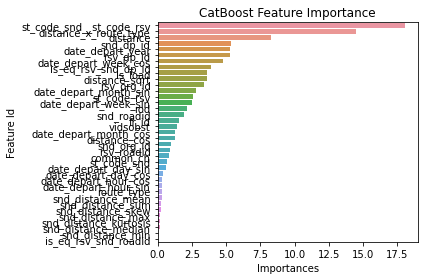

In [161]:
# feature importance
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = models[-1].get_feature_importance(prettified=True)
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('CatBoost Feature Importance')    
plt.tight_layout()
plt.show()


In [145]:
df_test = pd.read_parquet(r"df_test.parquet")

df_tests = dp.transform(df_test)
df_tests.head()

,st_code_snd,st_code_rsv,date_depart_year,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,date_depart_month_sin,date_depart_month_cos,date_depart_week_sin,date_depart_week_cos,date_depart_day_sin,date_depart_day_cos,date_depart_hour_sin,date_depart_hour_cos,is_eq_rsv_snd_roadid,is_eq_rsv_snd_dp_id,distance_sqrt,distance_cos,distance_x_route_type,st_code_snd__st_code_rsv
0,93.480622,84.730870,2,2261,3,0,2,10,102,2930.0,2974,2847,28,28,134,125,-1.000000,-1.836970e-16,-0.885456,-0.464723,0.201299,0.979530,0.707107,-7.071068e-01,1,0,54.129474,-0.448289,8790.0,78.828052
1,114.657197,90.160005,2,1653,4,1,8,9,102,1728.0,2957,6340,18,18,102,16,-0.866025,-5.000000e-01,-0.822984,-0.568065,-0.968077,-0.250653,-0.500000,-8.660254e-01,1,0,41.569219,0.992317,6912.0,136.793496
2,93.605155,119.930154,2,643,3,1,8,9,102,4393.0,1664,2128,0,0,1,124,0.500000,-8.660254e-01,0.568065,-0.822984,-0.848644,0.528964,-0.866025,-5.000000e-01,1,0,66.279710,0.494558,13179.0,187.876238
3,64.697417,140.362639,2,2261,4,0,8,975,111,1111.0,2974,2468,32,32,29,31,-0.500000,8.660254e-01,-0.822984,0.568065,0.724793,0.688967,0.866025,5.000000e-01,1,0,33.331667,0.432259,4444.0,49.107638
4,93.605155,84.730870,2,2261,3,0,15,40,111,19.0,2974,1098,29,29,117,117,0.500000,-8.660254e-01,0.663123,-0.748511,-0.299363,-0.954139,1.000000,6.123234e-17,1,1,4.358899,0.988705,57.0,84.324930


In [146]:
pred = np.mean([np.expm1(model.predict(df_tests)) for model in models], axis=0)
pred

array([172.25195968, 159.86936445, 215.02983931, ...,   6.10385436,
        75.85814354,  76.58322009])

In [57]:
# shape for pred <0 
pred[pred < 0].shape

(1,)

In [141]:
(pred).shape
# pred < 0?
# if pred < 0 then pred = 0
pred[pred < 0] = 0
(pred).shape

(1182903,)

In [142]:
sub = pd.read_csv(r"sub_example.csv")
sub['time'] = pred
sub.to_csv(r"ctb_log.csv", index=False)